In [39]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

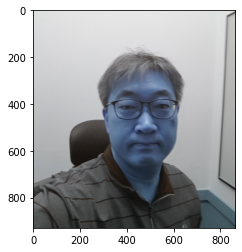

In [40]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/my_photo_resized.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

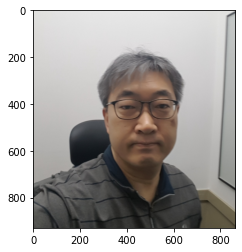

In [41]:
# OpenCV는 BGR로 사용하기 때문에 변환 필요. Matplotl이나 Dlib는 RGB로 인식
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [42]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()

In [43]:
# 얼굴의 bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
# Image pyramid는 upsampling을 통해 크기를 키우는 것

rectangles[[(312, 348) (633, 669)]]


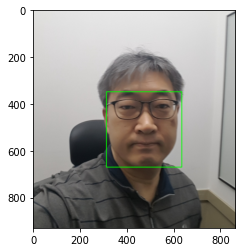

In [44]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # (이미지, 시작점,끝점, 선색깔, 박스외곽선 두께)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [ ]:
# Dlib의 제공되는 모델을 사용해보겠습니다. 먼저 공개되어 있는 weight file을 다운로드 받습니다. 
# 해당 모델파일은 bz2 압축파일 형태로 제공되어 압축을 풀어준 후 사용하겠습니다. 우분투에서 사용할 경우 다운로드 예제임. 

# $ wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
# $ mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/camera_sticker/models
# $ cd ~/aiffel/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2

In [45]:
# 저장한 Landmark 모델 불러 오기 
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)


In [46]:
# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환합니다.

list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


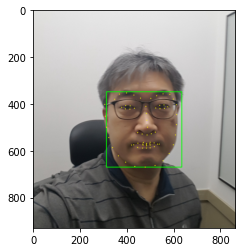

In [47]:
# 랜드마크를 영상에 출력

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # (이미지파일, 원의 중심좌표,반지름, 점색깔, 점두께(-1은 원 안을 채움))

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [48]:
# 인중의 중심점 구하기 

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코끝의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] 
    w = (landmark[30][0] - landmark[36][0])*2
    h = (landmark[48][1] - landmark[2][1])*2
    print('(x,y): (%d,%d)'%(x,y))
    print('(w,h):(%d,%d)'%(w,h))

(487, 499)
(x,y): (487,499)
(w,h):(220,152)


(152, 220, 3)


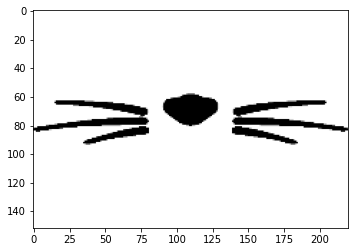

In [54]:
# 준비한 고양이 수염 이미지 읽고, 리사이즈 실행

sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_bearding.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
img_sticker = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
print (img_sticker.shape)
plt.imshow(img_sticker)

In [55]:
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표이기 때문입니다.

refined_x = x-w//2
refined_y = y-h//2
print('(x,y):(%d, %d)'%(refined_x, refined_y))


(x,y):(377, 423)


In [56]:
# -y 크기만큼 스티커를 crop 하고, top 의 x좌표와 y 좌표를 각각의 경우에 맞춰 원본 이미지의 경계 값으로 수정

if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:] # 사진을 crop하는 것
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (377,423)


In [59]:
# 원본 이미지에 스티커 적용
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지

img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
# 스티커 이미지에서 사용할 부분은 0 이 아닌 색이 있는 부분을 사용합니다. 
# 따라서 np.where를 통해 img_sticker 가 0 인 부분은 sticker_area를 사용하고 0이 아닌 부분을 img_sticker를 사용하시면 됩니다.

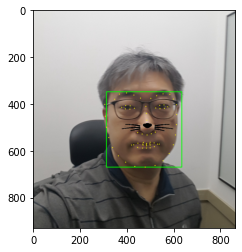

In [60]:
# 결과 이미지를 출력 

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

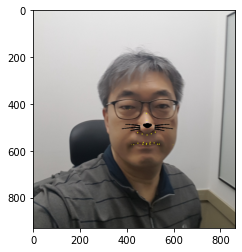

In [70]:
# Bounding box와 

# sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
#     np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
# plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
# plt.show()

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()